In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# Step 1: Define paths and configurations
data_dir = r"C:\Users\HP\OneDrive\Face mask Classifier\Compressed\Dataset"  # Ensure the directory structure has subfolders: 'without_mask', 'with_mask', 'improperly_worn_mask' under 'train' and 'test'.
batch_size = 32
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:

# Step 2: Data Preprocessing and Augmentation
transform_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [5]:

# Step 3: Load Data
# Step 3: Load Data
dataset = datasets.ImageFolder(
    data_dir, 
    transform=transform_train if "train" in data_dir else transform_test
)

# Split the dataset into train and test manually (70% train, 30% test)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Ensure dataset classes are correct
print("Classes:", dataset.classes)  # Should output: ['without_mask', 'with_mask', 'improperly_worn_mask']


Classes: ['mask_weared_incorrect', 'with_mask', 'without_mask']


In [6]:
# Step 4: Model Selection (Using ResNet)
class FaceMaskClassifier(nn.Module):
    def __init__(self):
        super(FaceMaskClassifier, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, 3)  # 3 classes: With Mask, Without Mask, Improperly Worn Mask

    def forward(self, x):
        return self.base_model(x)


In [7]:

model = FaceMaskClassifier().to(device)


D:\anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
D:\anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [22]:
# Step 6: Training Function
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    model.train()
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_steps = len(train_loader)
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            
            # Print progress for each batch
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{total_steps}], Training Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")

        # Save the best model
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved!")


In [26]:
# Step 7: Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    print("\nEvaluating model...")
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            print(f"\tBatch {batch_idx+1}/{len(test_loader)} evaluated.")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=dataset.classes))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


In [24]:
# Step 8: Training and Testing
print("\nStarting training...")
train_model(model, criterion, optimizer, train_loader, num_epochs)
print("\nTraining completed.")



Starting training...
Epoch [1/20], Step [1/197], Training Loss: 0.0156
Epoch [1/20], Step [2/197], Training Loss: 0.0150
Epoch [1/20], Step [3/197], Training Loss: 0.0200
Epoch [1/20], Step [4/197], Training Loss: 0.1697
Epoch [1/20], Step [5/197], Training Loss: 0.0107
Epoch [1/20], Step [6/197], Training Loss: 0.0391
Epoch [1/20], Step [7/197], Training Loss: 0.0643
Epoch [1/20], Step [8/197], Training Loss: 0.0697
Epoch [1/20], Step [9/197], Training Loss: 0.0248
Epoch [1/20], Step [10/197], Training Loss: 0.0276
Epoch [1/20], Step [11/197], Training Loss: 0.0426
Epoch [1/20], Step [12/197], Training Loss: 0.0350
Epoch [1/20], Step [13/197], Training Loss: 0.0177
Epoch [1/20], Step [14/197], Training Loss: 0.0521
Epoch [1/20], Step [15/197], Training Loss: 0.3786
Epoch [1/20], Step [16/197], Training Loss: 0.0228
Epoch [1/20], Step [17/197], Training Loss: 0.0253
Epoch [1/20], Step [18/197], Training Loss: 0.0041
Epoch [1/20], Step [19/197], Training Loss: 0.0257
Epoch [1/20], Step

Epoch [1/20], Step [161/197], Training Loss: 0.0103
Epoch [1/20], Step [162/197], Training Loss: 0.0096
Epoch [1/20], Step [163/197], Training Loss: 0.0258
Epoch [1/20], Step [164/197], Training Loss: 0.0331
Epoch [1/20], Step [165/197], Training Loss: 0.0915
Epoch [1/20], Step [166/197], Training Loss: 0.0330
Epoch [1/20], Step [167/197], Training Loss: 0.0088
Epoch [1/20], Step [168/197], Training Loss: 0.0070
Epoch [1/20], Step [169/197], Training Loss: 0.0428
Epoch [1/20], Step [170/197], Training Loss: 0.1663
Epoch [1/20], Step [171/197], Training Loss: 0.0158
Epoch [1/20], Step [172/197], Training Loss: 0.0591
Epoch [1/20], Step [173/197], Training Loss: 0.0646
Epoch [1/20], Step [174/197], Training Loss: 0.0324
Epoch [1/20], Step [175/197], Training Loss: 0.3264
Epoch [1/20], Step [176/197], Training Loss: 0.0271
Epoch [1/20], Step [177/197], Training Loss: 0.2597
Epoch [1/20], Step [178/197], Training Loss: 0.0784
Epoch [1/20], Step [179/197], Training Loss: 0.0440
Epoch [1/20]

Epoch [2/20], Step [123/197], Training Loss: 0.0032
Epoch [2/20], Step [124/197], Training Loss: 0.0265
Epoch [2/20], Step [125/197], Training Loss: 0.0765
Epoch [2/20], Step [126/197], Training Loss: 0.0086
Epoch [2/20], Step [127/197], Training Loss: 0.1513
Epoch [2/20], Step [128/197], Training Loss: 0.0098
Epoch [2/20], Step [129/197], Training Loss: 0.0463
Epoch [2/20], Step [130/197], Training Loss: 0.0708
Epoch [2/20], Step [131/197], Training Loss: 0.0060
Epoch [2/20], Step [132/197], Training Loss: 0.0058
Epoch [2/20], Step [133/197], Training Loss: 0.0066
Epoch [2/20], Step [134/197], Training Loss: 0.1015
Epoch [2/20], Step [135/197], Training Loss: 0.0072
Epoch [2/20], Step [136/197], Training Loss: 0.0296
Epoch [2/20], Step [137/197], Training Loss: 0.0518
Epoch [2/20], Step [138/197], Training Loss: 0.0057
Epoch [2/20], Step [139/197], Training Loss: 0.1390
Epoch [2/20], Step [140/197], Training Loss: 0.0530
Epoch [2/20], Step [141/197], Training Loss: 0.0151
Epoch [2/20]

Epoch [3/20], Step [85/197], Training Loss: 0.0207
Epoch [3/20], Step [86/197], Training Loss: 0.0238
Epoch [3/20], Step [87/197], Training Loss: 0.0050
Epoch [3/20], Step [88/197], Training Loss: 0.0058
Epoch [3/20], Step [89/197], Training Loss: 0.0033
Epoch [3/20], Step [90/197], Training Loss: 0.0023
Epoch [3/20], Step [91/197], Training Loss: 0.3828
Epoch [3/20], Step [92/197], Training Loss: 0.0045
Epoch [3/20], Step [93/197], Training Loss: 0.0139
Epoch [3/20], Step [94/197], Training Loss: 0.0628
Epoch [3/20], Step [95/197], Training Loss: 0.0670
Epoch [3/20], Step [96/197], Training Loss: 0.2425
Epoch [3/20], Step [97/197], Training Loss: 0.0430
Epoch [3/20], Step [98/197], Training Loss: 0.0009
Epoch [3/20], Step [99/197], Training Loss: 0.0270
Epoch [3/20], Step [100/197], Training Loss: 0.0575
Epoch [3/20], Step [101/197], Training Loss: 0.0069
Epoch [3/20], Step [102/197], Training Loss: 0.0047
Epoch [3/20], Step [103/197], Training Loss: 0.0009
Epoch [3/20], Step [104/197

Epoch [4/20], Step [46/197], Training Loss: 0.0050
Epoch [4/20], Step [47/197], Training Loss: 0.1036
Epoch [4/20], Step [48/197], Training Loss: 0.0130
Epoch [4/20], Step [49/197], Training Loss: 0.0092
Epoch [4/20], Step [50/197], Training Loss: 0.0589
Epoch [4/20], Step [51/197], Training Loss: 0.0648
Epoch [4/20], Step [52/197], Training Loss: 0.0477
Epoch [4/20], Step [53/197], Training Loss: 0.0060
Epoch [4/20], Step [54/197], Training Loss: 0.0026
Epoch [4/20], Step [55/197], Training Loss: 0.0063
Epoch [4/20], Step [56/197], Training Loss: 0.0557
Epoch [4/20], Step [57/197], Training Loss: 0.0006
Epoch [4/20], Step [58/197], Training Loss: 0.0012
Epoch [4/20], Step [59/197], Training Loss: 0.0736
Epoch [4/20], Step [60/197], Training Loss: 0.0013
Epoch [4/20], Step [61/197], Training Loss: 0.0797
Epoch [4/20], Step [62/197], Training Loss: 0.0422
Epoch [4/20], Step [63/197], Training Loss: 0.0477
Epoch [4/20], Step [64/197], Training Loss: 0.0028
Epoch [4/20], Step [65/197], Tr

Epoch [5/20], Step [7/197], Training Loss: 0.0007
Epoch [5/20], Step [8/197], Training Loss: 0.0008
Epoch [5/20], Step [9/197], Training Loss: 0.0105
Epoch [5/20], Step [10/197], Training Loss: 0.0014
Epoch [5/20], Step [11/197], Training Loss: 0.0021
Epoch [5/20], Step [12/197], Training Loss: 0.0245
Epoch [5/20], Step [13/197], Training Loss: 0.0008
Epoch [5/20], Step [14/197], Training Loss: 0.0482
Epoch [5/20], Step [15/197], Training Loss: 0.0009
Epoch [5/20], Step [16/197], Training Loss: 0.0714
Epoch [5/20], Step [17/197], Training Loss: 0.0106
Epoch [5/20], Step [18/197], Training Loss: 0.0082
Epoch [5/20], Step [19/197], Training Loss: 0.0023
Epoch [5/20], Step [20/197], Training Loss: 0.0018
Epoch [5/20], Step [21/197], Training Loss: 0.0012
Epoch [5/20], Step [22/197], Training Loss: 0.0362
Epoch [5/20], Step [23/197], Training Loss: 0.0028
Epoch [5/20], Step [24/197], Training Loss: 0.0049
Epoch [5/20], Step [25/197], Training Loss: 0.0100
Epoch [5/20], Step [26/197], Train

Epoch [5/20], Step [167/197], Training Loss: 0.0018
Epoch [5/20], Step [168/197], Training Loss: 0.0024
Epoch [5/20], Step [169/197], Training Loss: 0.0594
Epoch [5/20], Step [170/197], Training Loss: 0.0012
Epoch [5/20], Step [171/197], Training Loss: 0.0142
Epoch [5/20], Step [172/197], Training Loss: 0.0029
Epoch [5/20], Step [173/197], Training Loss: 0.0020
Epoch [5/20], Step [174/197], Training Loss: 0.0004
Epoch [5/20], Step [175/197], Training Loss: 0.0876
Epoch [5/20], Step [176/197], Training Loss: 0.0200
Epoch [5/20], Step [177/197], Training Loss: 0.0010
Epoch [5/20], Step [178/197], Training Loss: 0.0033
Epoch [5/20], Step [179/197], Training Loss: 0.0047
Epoch [5/20], Step [180/197], Training Loss: 0.0051
Epoch [5/20], Step [181/197], Training Loss: 0.1086
Epoch [5/20], Step [182/197], Training Loss: 0.0005
Epoch [5/20], Step [183/197], Training Loss: 0.0131
Epoch [5/20], Step [184/197], Training Loss: 0.0004
Epoch [5/20], Step [185/197], Training Loss: 0.0006
Epoch [5/20]

Epoch [6/20], Step [129/197], Training Loss: 0.0166
Epoch [6/20], Step [130/197], Training Loss: 0.0065
Epoch [6/20], Step [131/197], Training Loss: 0.0010
Epoch [6/20], Step [132/197], Training Loss: 0.0113
Epoch [6/20], Step [133/197], Training Loss: 0.0123
Epoch [6/20], Step [134/197], Training Loss: 0.0022
Epoch [6/20], Step [135/197], Training Loss: 0.0096
Epoch [6/20], Step [136/197], Training Loss: 0.0802
Epoch [6/20], Step [137/197], Training Loss: 0.0010
Epoch [6/20], Step [138/197], Training Loss: 0.0117
Epoch [6/20], Step [139/197], Training Loss: 0.0013
Epoch [6/20], Step [140/197], Training Loss: 0.0095
Epoch [6/20], Step [141/197], Training Loss: 0.1137
Epoch [6/20], Step [142/197], Training Loss: 0.0645
Epoch [6/20], Step [143/197], Training Loss: 0.0040
Epoch [6/20], Step [144/197], Training Loss: 0.0196
Epoch [6/20], Step [145/197], Training Loss: 0.0357
Epoch [6/20], Step [146/197], Training Loss: 0.0005
Epoch [6/20], Step [147/197], Training Loss: 0.0573
Epoch [6/20]

Epoch [7/20], Step [91/197], Training Loss: 0.0463
Epoch [7/20], Step [92/197], Training Loss: 0.0059
Epoch [7/20], Step [93/197], Training Loss: 0.0256
Epoch [7/20], Step [94/197], Training Loss: 0.0019
Epoch [7/20], Step [95/197], Training Loss: 0.0128
Epoch [7/20], Step [96/197], Training Loss: 0.0148
Epoch [7/20], Step [97/197], Training Loss: 0.0188
Epoch [7/20], Step [98/197], Training Loss: 0.0069
Epoch [7/20], Step [99/197], Training Loss: 0.0521
Epoch [7/20], Step [100/197], Training Loss: 0.0871
Epoch [7/20], Step [101/197], Training Loss: 0.0119
Epoch [7/20], Step [102/197], Training Loss: 0.0091
Epoch [7/20], Step [103/197], Training Loss: 0.0439
Epoch [7/20], Step [104/197], Training Loss: 0.0012
Epoch [7/20], Step [105/197], Training Loss: 0.0072
Epoch [7/20], Step [106/197], Training Loss: 0.0070
Epoch [7/20], Step [107/197], Training Loss: 0.0221
Epoch [7/20], Step [108/197], Training Loss: 0.0415
Epoch [7/20], Step [109/197], Training Loss: 0.1942
Epoch [7/20], Step [1

Epoch [8/20], Step [53/197], Training Loss: 0.0009
Epoch [8/20], Step [54/197], Training Loss: 0.0027
Epoch [8/20], Step [55/197], Training Loss: 0.0287
Epoch [8/20], Step [56/197], Training Loss: 0.0040
Epoch [8/20], Step [57/197], Training Loss: 0.0001
Epoch [8/20], Step [58/197], Training Loss: 0.2696
Epoch [8/20], Step [59/197], Training Loss: 0.0307
Epoch [8/20], Step [60/197], Training Loss: 0.0002
Epoch [8/20], Step [61/197], Training Loss: 0.0004
Epoch [8/20], Step [62/197], Training Loss: 0.0032
Epoch [8/20], Step [63/197], Training Loss: 0.0017
Epoch [8/20], Step [64/197], Training Loss: 0.0002
Epoch [8/20], Step [65/197], Training Loss: 0.0003
Epoch [8/20], Step [66/197], Training Loss: 0.0002
Epoch [8/20], Step [67/197], Training Loss: 0.0275
Epoch [8/20], Step [68/197], Training Loss: 0.0806
Epoch [8/20], Step [69/197], Training Loss: 0.0211
Epoch [8/20], Step [70/197], Training Loss: 0.0006
Epoch [8/20], Step [71/197], Training Loss: 0.0051
Epoch [8/20], Step [72/197], Tr

Epoch [9/20], Step [15/197], Training Loss: 0.0007
Epoch [9/20], Step [16/197], Training Loss: 0.0198
Epoch [9/20], Step [17/197], Training Loss: 0.0012
Epoch [9/20], Step [18/197], Training Loss: 0.0023
Epoch [9/20], Step [19/197], Training Loss: 0.0006
Epoch [9/20], Step [20/197], Training Loss: 0.0001
Epoch [9/20], Step [21/197], Training Loss: 0.0002
Epoch [9/20], Step [22/197], Training Loss: 0.0006
Epoch [9/20], Step [23/197], Training Loss: 0.0002
Epoch [9/20], Step [24/197], Training Loss: 0.0032
Epoch [9/20], Step [25/197], Training Loss: 0.0002
Epoch [9/20], Step [26/197], Training Loss: 0.0014
Epoch [9/20], Step [27/197], Training Loss: 0.0002
Epoch [9/20], Step [28/197], Training Loss: 0.0000
Epoch [9/20], Step [29/197], Training Loss: 0.0023
Epoch [9/20], Step [30/197], Training Loss: 0.0003
Epoch [9/20], Step [31/197], Training Loss: 0.0001
Epoch [9/20], Step [32/197], Training Loss: 0.0008
Epoch [9/20], Step [33/197], Training Loss: 0.0014
Epoch [9/20], Step [34/197], Tr

Epoch [9/20], Step [175/197], Training Loss: 0.0009
Epoch [9/20], Step [176/197], Training Loss: 0.0121
Epoch [9/20], Step [177/197], Training Loss: 0.0193
Epoch [9/20], Step [178/197], Training Loss: 0.0891
Epoch [9/20], Step [179/197], Training Loss: 0.0013
Epoch [9/20], Step [180/197], Training Loss: 0.0039
Epoch [9/20], Step [181/197], Training Loss: 0.0011
Epoch [9/20], Step [182/197], Training Loss: 0.0570
Epoch [9/20], Step [183/197], Training Loss: 0.1457
Epoch [9/20], Step [184/197], Training Loss: 0.0057
Epoch [9/20], Step [185/197], Training Loss: 0.0065
Epoch [9/20], Step [186/197], Training Loss: 0.0018
Epoch [9/20], Step [187/197], Training Loss: 0.1771
Epoch [9/20], Step [188/197], Training Loss: 0.0001
Epoch [9/20], Step [189/197], Training Loss: 0.0069
Epoch [9/20], Step [190/197], Training Loss: 0.0203
Epoch [9/20], Step [191/197], Training Loss: 0.0028
Epoch [9/20], Step [192/197], Training Loss: 0.0195
Epoch [9/20], Step [193/197], Training Loss: 0.0004
Epoch [9/20]

Epoch [10/20], Step [135/197], Training Loss: 0.0102
Epoch [10/20], Step [136/197], Training Loss: 0.0001
Epoch [10/20], Step [137/197], Training Loss: 0.0092
Epoch [10/20], Step [138/197], Training Loss: 0.0020
Epoch [10/20], Step [139/197], Training Loss: 0.0000
Epoch [10/20], Step [140/197], Training Loss: 0.0015
Epoch [10/20], Step [141/197], Training Loss: 0.0017
Epoch [10/20], Step [142/197], Training Loss: 0.0039
Epoch [10/20], Step [143/197], Training Loss: 0.0060
Epoch [10/20], Step [144/197], Training Loss: 0.0015
Epoch [10/20], Step [145/197], Training Loss: 0.0038
Epoch [10/20], Step [146/197], Training Loss: 0.0038
Epoch [10/20], Step [147/197], Training Loss: 0.0125
Epoch [10/20], Step [148/197], Training Loss: 0.0370
Epoch [10/20], Step [149/197], Training Loss: 0.0002
Epoch [10/20], Step [150/197], Training Loss: 0.0119
Epoch [10/20], Step [151/197], Training Loss: 0.0002
Epoch [10/20], Step [152/197], Training Loss: 0.0013
Epoch [10/20], Step [153/197], Training Loss: 

Epoch [11/20], Step [94/197], Training Loss: 0.0015
Epoch [11/20], Step [95/197], Training Loss: 0.0005
Epoch [11/20], Step [96/197], Training Loss: 0.0044
Epoch [11/20], Step [97/197], Training Loss: 0.0005
Epoch [11/20], Step [98/197], Training Loss: 0.0500
Epoch [11/20], Step [99/197], Training Loss: 0.0379
Epoch [11/20], Step [100/197], Training Loss: 0.0025
Epoch [11/20], Step [101/197], Training Loss: 0.0671
Epoch [11/20], Step [102/197], Training Loss: 0.0045
Epoch [11/20], Step [103/197], Training Loss: 0.0005
Epoch [11/20], Step [104/197], Training Loss: 0.0010
Epoch [11/20], Step [105/197], Training Loss: 0.0081
Epoch [11/20], Step [106/197], Training Loss: 0.0102
Epoch [11/20], Step [107/197], Training Loss: 0.0216
Epoch [11/20], Step [108/197], Training Loss: 0.0046
Epoch [11/20], Step [109/197], Training Loss: 0.0067
Epoch [11/20], Step [110/197], Training Loss: 0.0310
Epoch [11/20], Step [111/197], Training Loss: 0.0061
Epoch [11/20], Step [112/197], Training Loss: 0.0025

Epoch [12/20], Step [53/197], Training Loss: 0.0050
Epoch [12/20], Step [54/197], Training Loss: 0.0044
Epoch [12/20], Step [55/197], Training Loss: 0.0209
Epoch [12/20], Step [56/197], Training Loss: 0.1013
Epoch [12/20], Step [57/197], Training Loss: 0.0427
Epoch [12/20], Step [58/197], Training Loss: 0.0726
Epoch [12/20], Step [59/197], Training Loss: 0.0509
Epoch [12/20], Step [60/197], Training Loss: 0.1770
Epoch [12/20], Step [61/197], Training Loss: 0.0074
Epoch [12/20], Step [62/197], Training Loss: 0.0679
Epoch [12/20], Step [63/197], Training Loss: 0.0005
Epoch [12/20], Step [64/197], Training Loss: 0.0126
Epoch [12/20], Step [65/197], Training Loss: 0.0744
Epoch [12/20], Step [66/197], Training Loss: 0.0815
Epoch [12/20], Step [67/197], Training Loss: 0.0093
Epoch [12/20], Step [68/197], Training Loss: 0.1042
Epoch [12/20], Step [69/197], Training Loss: 0.0614
Epoch [12/20], Step [70/197], Training Loss: 0.0013
Epoch [12/20], Step [71/197], Training Loss: 0.0014
Epoch [12/20

Epoch [13/20], Step [12/197], Training Loss: 0.0295
Epoch [13/20], Step [13/197], Training Loss: 0.0239
Epoch [13/20], Step [14/197], Training Loss: 0.0057
Epoch [13/20], Step [15/197], Training Loss: 0.0013
Epoch [13/20], Step [16/197], Training Loss: 0.1481
Epoch [13/20], Step [17/197], Training Loss: 0.0058
Epoch [13/20], Step [18/197], Training Loss: 0.0412
Epoch [13/20], Step [19/197], Training Loss: 0.0374
Epoch [13/20], Step [20/197], Training Loss: 0.1316
Epoch [13/20], Step [21/197], Training Loss: 0.0019
Epoch [13/20], Step [22/197], Training Loss: 0.0012
Epoch [13/20], Step [23/197], Training Loss: 0.0022
Epoch [13/20], Step [24/197], Training Loss: 0.0334
Epoch [13/20], Step [25/197], Training Loss: 0.0025
Epoch [13/20], Step [26/197], Training Loss: 0.0005
Epoch [13/20], Step [27/197], Training Loss: 0.1726
Epoch [13/20], Step [28/197], Training Loss: 0.0553
Epoch [13/20], Step [29/197], Training Loss: 0.0268
Epoch [13/20], Step [30/197], Training Loss: 0.0002
Epoch [13/20

Epoch [13/20], Step [169/197], Training Loss: 0.0465
Epoch [13/20], Step [170/197], Training Loss: 0.0007
Epoch [13/20], Step [171/197], Training Loss: 0.0030
Epoch [13/20], Step [172/197], Training Loss: 0.0012
Epoch [13/20], Step [173/197], Training Loss: 0.0007
Epoch [13/20], Step [174/197], Training Loss: 0.0017
Epoch [13/20], Step [175/197], Training Loss: 0.0002
Epoch [13/20], Step [176/197], Training Loss: 0.0015
Epoch [13/20], Step [177/197], Training Loss: 0.0002
Epoch [13/20], Step [178/197], Training Loss: 0.0013
Epoch [13/20], Step [179/197], Training Loss: 0.0007
Epoch [13/20], Step [180/197], Training Loss: 0.0110
Epoch [13/20], Step [181/197], Training Loss: 0.0043
Epoch [13/20], Step [182/197], Training Loss: 0.0075
Epoch [13/20], Step [183/197], Training Loss: 0.0007
Epoch [13/20], Step [184/197], Training Loss: 0.0004
Epoch [13/20], Step [185/197], Training Loss: 0.0004
Epoch [13/20], Step [186/197], Training Loss: 0.0004
Epoch [13/20], Step [187/197], Training Loss: 

Epoch [14/20], Step [128/197], Training Loss: 0.0084
Epoch [14/20], Step [129/197], Training Loss: 0.0008
Epoch [14/20], Step [130/197], Training Loss: 0.2132
Epoch [14/20], Step [131/197], Training Loss: 0.0000
Epoch [14/20], Step [132/197], Training Loss: 0.0015
Epoch [14/20], Step [133/197], Training Loss: 0.0011
Epoch [14/20], Step [134/197], Training Loss: 0.0018
Epoch [14/20], Step [135/197], Training Loss: 0.0007
Epoch [14/20], Step [136/197], Training Loss: 0.0002
Epoch [14/20], Step [137/197], Training Loss: 0.0001
Epoch [14/20], Step [138/197], Training Loss: 0.0018
Epoch [14/20], Step [139/197], Training Loss: 0.0304
Epoch [14/20], Step [140/197], Training Loss: 0.0027
Epoch [14/20], Step [141/197], Training Loss: 0.0013
Epoch [14/20], Step [142/197], Training Loss: 0.0009
Epoch [14/20], Step [143/197], Training Loss: 0.0150
Epoch [14/20], Step [144/197], Training Loss: 0.0003
Epoch [14/20], Step [145/197], Training Loss: 0.0027
Epoch [14/20], Step [146/197], Training Loss: 

Epoch [15/20], Step [87/197], Training Loss: 0.0001
Epoch [15/20], Step [88/197], Training Loss: 0.0000
Epoch [15/20], Step [89/197], Training Loss: 0.0196
Epoch [15/20], Step [90/197], Training Loss: 0.0004
Epoch [15/20], Step [91/197], Training Loss: 0.0024
Epoch [15/20], Step [92/197], Training Loss: 0.0242
Epoch [15/20], Step [93/197], Training Loss: 0.0008
Epoch [15/20], Step [94/197], Training Loss: 0.0001
Epoch [15/20], Step [95/197], Training Loss: 0.0019
Epoch [15/20], Step [96/197], Training Loss: 0.0002
Epoch [15/20], Step [97/197], Training Loss: 0.0006
Epoch [15/20], Step [98/197], Training Loss: 0.0006
Epoch [15/20], Step [99/197], Training Loss: 0.0026
Epoch [15/20], Step [100/197], Training Loss: 0.0000
Epoch [15/20], Step [101/197], Training Loss: 0.0008
Epoch [15/20], Step [102/197], Training Loss: 0.0349
Epoch [15/20], Step [103/197], Training Loss: 0.0002
Epoch [15/20], Step [104/197], Training Loss: 0.0015
Epoch [15/20], Step [105/197], Training Loss: 0.0071
Epoch 

Epoch [16/20], Step [45/197], Training Loss: 0.0012
Epoch [16/20], Step [46/197], Training Loss: 0.0011
Epoch [16/20], Step [47/197], Training Loss: 0.0019
Epoch [16/20], Step [48/197], Training Loss: 0.0051
Epoch [16/20], Step [49/197], Training Loss: 0.0046
Epoch [16/20], Step [50/197], Training Loss: 0.0001
Epoch [16/20], Step [51/197], Training Loss: 0.0003
Epoch [16/20], Step [52/197], Training Loss: 0.0019
Epoch [16/20], Step [53/197], Training Loss: 0.0007
Epoch [16/20], Step [54/197], Training Loss: 0.0927
Epoch [16/20], Step [55/197], Training Loss: 0.0004
Epoch [16/20], Step [56/197], Training Loss: 0.0020
Epoch [16/20], Step [57/197], Training Loss: 0.0002
Epoch [16/20], Step [58/197], Training Loss: 0.0003
Epoch [16/20], Step [59/197], Training Loss: 0.0581
Epoch [16/20], Step [60/197], Training Loss: 0.0002
Epoch [16/20], Step [61/197], Training Loss: 0.0001
Epoch [16/20], Step [62/197], Training Loss: 0.0009
Epoch [16/20], Step [63/197], Training Loss: 0.0010
Epoch [16/20

Epoch [17/20], Step [4/197], Training Loss: 0.0061
Epoch [17/20], Step [5/197], Training Loss: 0.0159
Epoch [17/20], Step [6/197], Training Loss: 0.1718
Epoch [17/20], Step [7/197], Training Loss: 0.0002
Epoch [17/20], Step [8/197], Training Loss: 0.0426
Epoch [17/20], Step [9/197], Training Loss: 0.0108
Epoch [17/20], Step [10/197], Training Loss: 0.0046
Epoch [17/20], Step [11/197], Training Loss: 0.0144
Epoch [17/20], Step [12/197], Training Loss: 0.0019
Epoch [17/20], Step [13/197], Training Loss: 0.0010
Epoch [17/20], Step [14/197], Training Loss: 0.0027
Epoch [17/20], Step [15/197], Training Loss: 0.0006
Epoch [17/20], Step [16/197], Training Loss: 0.0004
Epoch [17/20], Step [17/197], Training Loss: 0.0077
Epoch [17/20], Step [18/197], Training Loss: 0.0054
Epoch [17/20], Step [19/197], Training Loss: 0.0224
Epoch [17/20], Step [20/197], Training Loss: 0.0821
Epoch [17/20], Step [21/197], Training Loss: 0.0019
Epoch [17/20], Step [22/197], Training Loss: 0.0059
Epoch [17/20], Ste

Epoch [17/20], Step [161/197], Training Loss: 0.0002
Epoch [17/20], Step [162/197], Training Loss: 0.0009
Epoch [17/20], Step [163/197], Training Loss: 0.0015
Epoch [17/20], Step [164/197], Training Loss: 0.0002
Epoch [17/20], Step [165/197], Training Loss: 0.0004
Epoch [17/20], Step [166/197], Training Loss: 0.0027
Epoch [17/20], Step [167/197], Training Loss: 0.0014
Epoch [17/20], Step [168/197], Training Loss: 0.0000
Epoch [17/20], Step [169/197], Training Loss: 0.0005
Epoch [17/20], Step [170/197], Training Loss: 0.0015
Epoch [17/20], Step [171/197], Training Loss: 0.0243
Epoch [17/20], Step [172/197], Training Loss: 0.0023
Epoch [17/20], Step [173/197], Training Loss: 0.0063
Epoch [17/20], Step [174/197], Training Loss: 0.0003
Epoch [17/20], Step [175/197], Training Loss: 0.0011
Epoch [17/20], Step [176/197], Training Loss: 0.0026
Epoch [17/20], Step [177/197], Training Loss: 0.0010
Epoch [17/20], Step [178/197], Training Loss: 0.0093
Epoch [17/20], Step [179/197], Training Loss: 

Epoch [18/20], Step [120/197], Training Loss: 0.0001
Epoch [18/20], Step [121/197], Training Loss: 0.0001
Epoch [18/20], Step [122/197], Training Loss: 0.0003
Epoch [18/20], Step [123/197], Training Loss: 0.0000
Epoch [18/20], Step [124/197], Training Loss: 0.0003
Epoch [18/20], Step [125/197], Training Loss: 0.0001
Epoch [18/20], Step [126/197], Training Loss: 0.0000
Epoch [18/20], Step [127/197], Training Loss: 0.0000
Epoch [18/20], Step [128/197], Training Loss: 0.0000
Epoch [18/20], Step [129/197], Training Loss: 0.0003
Epoch [18/20], Step [130/197], Training Loss: 0.0000
Epoch [18/20], Step [131/197], Training Loss: 0.0001
Epoch [18/20], Step [132/197], Training Loss: 0.0002
Epoch [18/20], Step [133/197], Training Loss: 0.0000
Epoch [18/20], Step [134/197], Training Loss: 0.0000
Epoch [18/20], Step [135/197], Training Loss: 0.0000
Epoch [18/20], Step [136/197], Training Loss: 0.0006
Epoch [18/20], Step [137/197], Training Loss: 0.0001
Epoch [18/20], Step [138/197], Training Loss: 

Epoch [19/20], Step [79/197], Training Loss: 0.0000
Epoch [19/20], Step [80/197], Training Loss: 0.0020
Epoch [19/20], Step [81/197], Training Loss: 0.0001
Epoch [19/20], Step [82/197], Training Loss: 0.0053
Epoch [19/20], Step [83/197], Training Loss: 0.0019
Epoch [19/20], Step [84/197], Training Loss: 0.0375
Epoch [19/20], Step [85/197], Training Loss: 0.0001
Epoch [19/20], Step [86/197], Training Loss: 0.0001
Epoch [19/20], Step [87/197], Training Loss: 0.0001
Epoch [19/20], Step [88/197], Training Loss: 0.0006
Epoch [19/20], Step [89/197], Training Loss: 0.0000
Epoch [19/20], Step [90/197], Training Loss: 0.0004
Epoch [19/20], Step [91/197], Training Loss: 0.0000
Epoch [19/20], Step [92/197], Training Loss: 0.0001
Epoch [19/20], Step [93/197], Training Loss: 0.0000
Epoch [19/20], Step [94/197], Training Loss: 0.0000
Epoch [19/20], Step [95/197], Training Loss: 0.0018
Epoch [19/20], Step [96/197], Training Loss: 0.0000
Epoch [19/20], Step [97/197], Training Loss: 0.0001
Epoch [19/20

Epoch [20/20], Step [38/197], Training Loss: 0.0017
Epoch [20/20], Step [39/197], Training Loss: 0.0000
Epoch [20/20], Step [40/197], Training Loss: 0.0001
Epoch [20/20], Step [41/197], Training Loss: 0.0001
Epoch [20/20], Step [42/197], Training Loss: 0.0507
Epoch [20/20], Step [43/197], Training Loss: 0.0000
Epoch [20/20], Step [44/197], Training Loss: 0.0003
Epoch [20/20], Step [45/197], Training Loss: 0.0007
Epoch [20/20], Step [46/197], Training Loss: 0.0000
Epoch [20/20], Step [47/197], Training Loss: 0.0001
Epoch [20/20], Step [48/197], Training Loss: 0.0003
Epoch [20/20], Step [49/197], Training Loss: 0.0004
Epoch [20/20], Step [50/197], Training Loss: 0.0009
Epoch [20/20], Step [51/197], Training Loss: 0.0000
Epoch [20/20], Step [52/197], Training Loss: 0.0004
Epoch [20/20], Step [53/197], Training Loss: 0.0001
Epoch [20/20], Step [54/197], Training Loss: 0.0000
Epoch [20/20], Step [55/197], Training Loss: 0.0025
Epoch [20/20], Step [56/197], Training Loss: 0.0002
Epoch [20/20

Epoch [20/20], Step [194/197], Training Loss: 0.0022
Epoch [20/20], Step [195/197], Training Loss: 0.0082
Epoch [20/20], Step [196/197], Training Loss: 0.0480
Epoch [20/20], Step [197/197], Training Loss: 0.1865
Epoch [20/20], Average Loss: 0.0232

Training completed.


In [27]:

evaluate_model(model, test_loader)

# Load the best model for final evaluation
print("\nLoading best model for final evaluation...")
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, test_loader)



Evaluating model...
	Batch 1/85 evaluated.
	Batch 2/85 evaluated.
	Batch 3/85 evaluated.
	Batch 4/85 evaluated.
	Batch 5/85 evaluated.
	Batch 6/85 evaluated.
	Batch 7/85 evaluated.
	Batch 8/85 evaluated.
	Batch 9/85 evaluated.
	Batch 10/85 evaluated.
	Batch 11/85 evaluated.
	Batch 12/85 evaluated.
	Batch 13/85 evaluated.
	Batch 14/85 evaluated.
	Batch 15/85 evaluated.
	Batch 16/85 evaluated.
	Batch 17/85 evaluated.
	Batch 18/85 evaluated.
	Batch 19/85 evaluated.
	Batch 20/85 evaluated.
	Batch 21/85 evaluated.
	Batch 22/85 evaluated.
	Batch 23/85 evaluated.
	Batch 24/85 evaluated.
	Batch 25/85 evaluated.
	Batch 26/85 evaluated.
	Batch 27/85 evaluated.
	Batch 28/85 evaluated.
	Batch 29/85 evaluated.
	Batch 30/85 evaluated.
	Batch 31/85 evaluated.
	Batch 32/85 evaluated.
	Batch 33/85 evaluated.
	Batch 34/85 evaluated.
	Batch 35/85 evaluated.
	Batch 36/85 evaluated.
	Batch 37/85 evaluated.
	Batch 38/85 evaluated.
	Batch 39/85 evaluated.
	Batch 40/85 evaluated.
	Batch 41/85 evaluated.
	Bat

In [28]:
# Load the best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))
evaluate_model(model, test_loader)



Evaluating model...
	Batch 1/85 evaluated.
	Batch 2/85 evaluated.
	Batch 3/85 evaluated.
	Batch 4/85 evaluated.
	Batch 5/85 evaluated.
	Batch 6/85 evaluated.
	Batch 7/85 evaluated.
	Batch 8/85 evaluated.
	Batch 9/85 evaluated.
	Batch 10/85 evaluated.
	Batch 11/85 evaluated.
	Batch 12/85 evaluated.
	Batch 13/85 evaluated.
	Batch 14/85 evaluated.
	Batch 15/85 evaluated.
	Batch 16/85 evaluated.
	Batch 17/85 evaluated.
	Batch 18/85 evaluated.
	Batch 19/85 evaluated.
	Batch 20/85 evaluated.
	Batch 21/85 evaluated.
	Batch 22/85 evaluated.
	Batch 23/85 evaluated.
	Batch 24/85 evaluated.
	Batch 25/85 evaluated.
	Batch 26/85 evaluated.
	Batch 27/85 evaluated.
	Batch 28/85 evaluated.
	Batch 29/85 evaluated.
	Batch 30/85 evaluated.
	Batch 31/85 evaluated.
	Batch 32/85 evaluated.
	Batch 33/85 evaluated.
	Batch 34/85 evaluated.
	Batch 35/85 evaluated.
	Batch 36/85 evaluated.
	Batch 37/85 evaluated.
	Batch 38/85 evaluated.


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


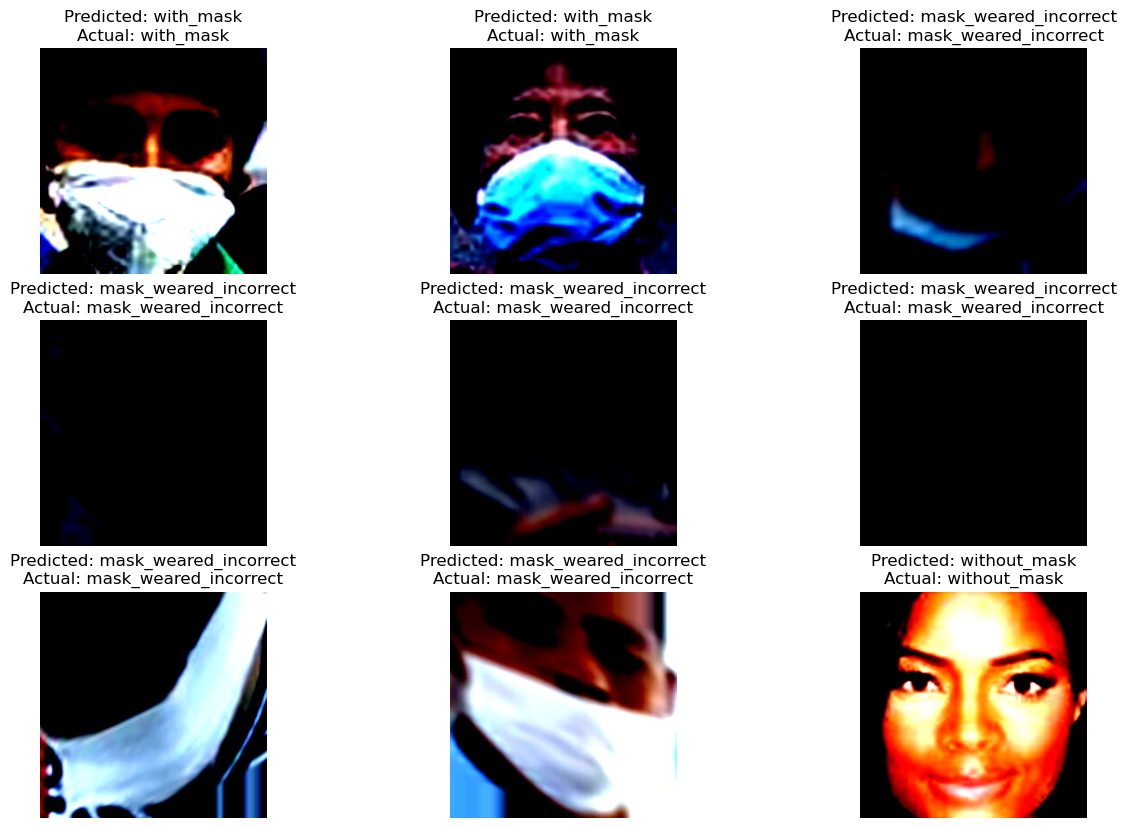

In [30]:

# Step 10: Visualize Some Predictions
def visualize_predictions(model, test_loader):
    model.eval()
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(np.transpose(inputs[i].cpu().numpy(), (1, 2, 0)))
        plt.title(f"Predicted: {dataset.classes[preds[i]]}\nActual: {dataset.classes[labels[i]]}")
        plt.axis("off")
    plt.show()

visualize_predictions(model, test_loader)
